In [16]:
import ipynb_setup

import numpy as np

from src.data_loader.data_loader import Dataset

from src.model.catboost_model import CatBoost
from src.model.adaboost import AdaBoost
from src.model.extra_tree import ExtraTree
from src.model.lgbm import LGBM
from src.model.xgb import XGB

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline

In [3]:
CATEGORICAL_FEATURES = ['Condition', 'Clouds', 'Day/Night', 'Snow_Priority']
path = '../data/processed/with_traffic_count.csv'
dataset = Dataset(path, CATEGORICAL_FEATURES)
x, x_test, y, y_test = dataset.clean_and_encode_data()
len(x), len(x_test)

Creating ordinal representations of circular features (Month/Year/Weekday/Minute)
Columns: ['FeelsLike', 'Precip.', 'StreetWidth_Min', 'POSTED_SPEED', 'Number_Travel_Lanes', 'Number_Park_Lanes', 'Number_Total_Lanes', 'TRAFFIC_C', 'TRAFFIC_1hPtoC', 'LL_X', 'LL_Y', 'LL_Z', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'DOW_SIN', 'DOW_COS', 'Condition_CLD', 'Condition_LVS', 'Condition_RD', 'Clouds_BKN', 'Clouds_CLR', 'Clouds_FEW', 'Clouds_OVC', 'Clouds_SCT', 'Day/Night_D', 'Day/Night_N', 'Snow_Priority_C', 'Snow_Priority_H', 'Snow_Priority_S', 'Snow_Priority_V']


(20579, 2287)

# With traffic count

In [4]:
x = x.drop(columns=['TRAFFIC_C'])
x_test = x_test.drop(columns=['TRAFFIC_C'])
counter = Counter(y)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.5, random_state=42)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x_new, y_new = pipeline.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(y_new)
print(counter)

class_weights = compute_sample_weight('balanced', y_new)

Counter({0: 16597, 1: 3982})
Counter({0: 16597, 1: 8298})


In [26]:
# from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def train_extra_trees_model(x, y):
    class_weights = compute_sample_weight('balanced', y)
    parameters = {'n_estimators':[30, 40, 50, 75], 'max_depth':[None, 3, 5, 7, 10],
                 'max_features':['auto', 'log2', 0.4, 0.8], 'bootstrap': [True, False]}
    etc = ExtraTreesClassifier(random_state = 42)
    clf = HalvingGridSearchCV(etc, parameters, return_train_score=True, verbose=3)
    extra_tree_model = clf.fit(x, y, sample_weight=class_weights)
    return extra_tree_model

def train_model_lgbm(x, y):
    class_weights = compute_sample_weight('balanced', y)
    parameters = {'n_estimators':[100, 80, 120],
                  'learning_rate': [0.05, 0.1, 0.3], 
                  'num_leaves':[23, 31, 45],
                  'max_depth':[-1, 3, 5, 7], 
                 'feature_fraction':[1.0, 0.9, 0.7]}
    lgbm_model = LGBMClassifier(random_state = 42, application='binary')
    clf = HalvingGridSearchCV(lgbm_model, parameters, return_train_score=True, verbose=1)
    model = clf.fit(x, y, sample_weight=class_weights)
    return model

def train_xgbost(x, y):
    param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
    }
    gsearch1 = HalvingGridSearchCV(XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
        gamma=0, subsample=0.8, colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        seed=27,
        num_class=2,
        verbose=1,
        use_label_encoder=False), param_grid = param_test1, n_jobs=-1, return_train_score=True, verbose=3)
    class_weights = compute_sample_weight('balanced', y)
    gsearch1.fit(x, y, sample_weight=class_weights)
    return gsearch1

def train_CatBoost(x, y):
    class_weights = compute_sample_weight('balanced', y)
    #'boosting':['gbdt', 'goss'], 
    parameters = {
                  'learning_rate': [0.1, 0.3, 0.5], 
                  'depth':[4, 7, 10]
                 }
    cat = CatBoostClassifier(auto_class_weights='Balanced', 
                             l2_leaf_reg=3.5, rsm=0.98, verbose=50,
                            iterations=2800)
    clf = HalvingGridSearchCV(cat, parameters, return_train_score=True, verbose=1)
#     etc = ExtraTreesClassifier(n_estimators=50, random_state=42,bootstrap=True, verbose=2)    
    model = clf.fit(x, y, sample_weight=class_weights)
    return model

In [14]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(extra_tree_model, x, y_test):
    prediction = extra_tree_model.predict(x)
    accuracy = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    f1_2 = f1_score(y_test, prediction, average='weighted')
    report = classification_report(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n ROC_AUC: \n {roc_auc} \n Classification report: \n {report}')

    print(confusion_matrix(prediction, y_test))

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

    plt.show()
    
import pickle

def save_model(file_name, model):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

In [7]:
def plot_importance(importance, feature_name, ax=None, height=0.2,
                    xlim=None, ylim=None, title='Feature importance',
                    xlabel='Feature importance', ylabel='Features',
                    importance_type='split', max_num_features=None,
                    ignore_zero=True, figsize=None, dpi=None, grid=True,
                    precision=3, **kwargs):

    tuples = sorted(zip(feature_name, importance), key=lambda x: x[1])
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
    if max_num_features is not None and max_num_features > 0:
        tuples = tuples[-max_num_features:]
    labels, values = zip(*tuples)

    if ax is None:
        if figsize is not None:
            _check_not_tuple_of_2_elements(figsize, 'figsize')
        _, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=height, **kwargs)

    for x, y in zip(values, ylocs):
        ax.text(x + 1, y,
                _float2str(x, precision) if importance_type == 'gain' else x,
                va='center')

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)

    if xlim is not None:
        _check_not_tuple_of_2_elements(xlim, 'xlim')
    else:
        xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)

    if ylim is not None:
        _check_not_tuple_of_2_elements(ylim, 'ylim')
    else:
        ylim = (-1, len(values))
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(grid)
    return ax

Accuracy: 
 0.8627022299956275 
 F1: 
 0.8627022299956275 
 F1_2: 
 0.8347205965724558 
 ROC_AUC: 
 0.6524591981384735 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      1854
           1       0.89      0.31      0.46       433

    accuracy                           0.86      2287
   macro avg       0.87      0.65      0.69      2287
weighted avg       0.87      0.86      0.83      2287

[[1837  297]
 [  17  136]]


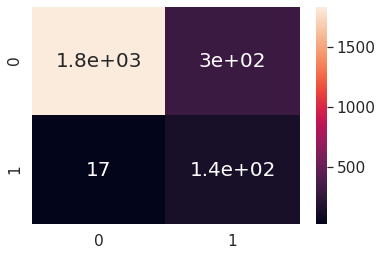

ExtraTreesClassifier(bootstrap=True, max_features='log2', n_estimators=50,
                     random_state=42)
0.8739995978282726
{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

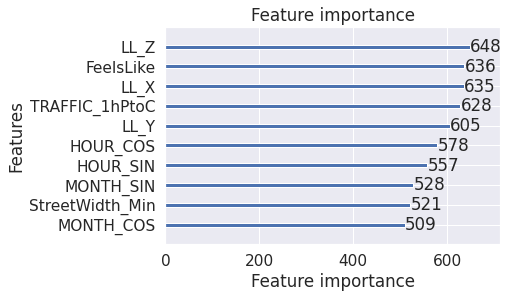

In [17]:
extra_tree_model = train_extra_trees_model(x_new, y_new)
test_model(extra_tree_model, x_test, y_test)
file_name = './extraTreeTrafficCount.pkl'
save_model(file_name, extra_tree_model)
print(extra_tree_model.best_estimator_)
print(extra_tree_model.best_score_)
print(extra_tree_model.best_params_)
plot_importance((extra_tree_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 102
max_resources_: 24895
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 324
n_resources: 102
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

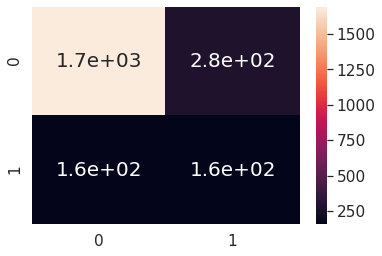

LGBMClassifier(application='binary', feature_fraction=0.9, learning_rate=0.3,
               num_leaves=45, random_state=42)
0.8344563243897518
{'feature_fraction': 0.9, 'learning_rate': 0.3, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 45}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

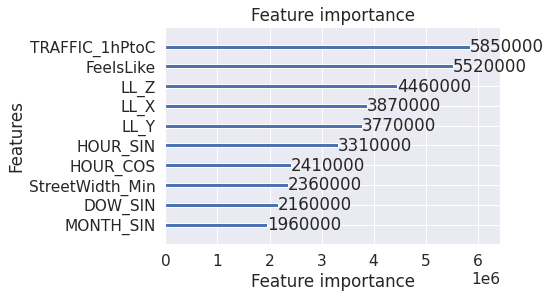

In [22]:
lgbm_model = train_model_lgbm(x_new, y_new)
test_model(lgbm_model, x_test, y_test)
file_name = './lgbmTrafficCount.pkl'
save_model(file_name, lgbm_model)
print(lgbm_model.best_estimator_)
print(lgbm_model.best_score_)
print(lgbm_model.best_params_)
plot_importance((lgbm_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2766
max_resources_: 24895
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 2766
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 8298
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 24894
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[20:10:21] WARNING: ../src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:10:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. 

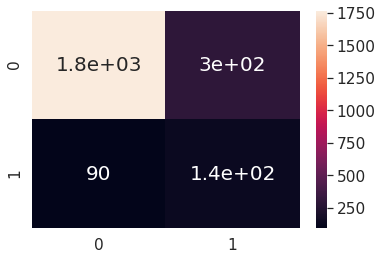

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_class=2,
              num_parallel_tree=1, objective='multi:softmax', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=27,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
0.8556046605062274
{'max_depth': 9, 'min_child_weight': 1}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

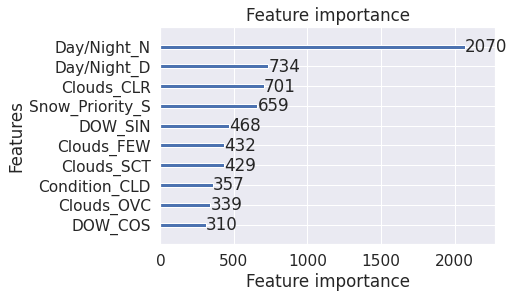

In [23]:
xgboost_model = train_xgbost(x_new, y_new)
test_model(xgboost_model, x_test, y_test)
file_name = './xgboost_modelTrafficCount.pkl'
save_model(file_name, xgboost_model)
print(xgboost_model.best_estimator_)
print(xgboost_model.best_score_)
print(xgboost_model.best_params_)
plot_importance((xgboost_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2766
max_resources_: 24895
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2766
Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 0.6679287	total: 49.3ms	remaining: 2m 18s
50:	learn: 0.4616680	total: 210ms	remaining: 11.3s
100:	learn: 0.3916594	total: 344ms	remaining: 9.19s
150:	learn: 0.3321530	total: 518ms	remaining: 9.08s
200:	learn: 0.2861105	total: 639ms	remaining: 8.26s
250:	learn: 0.2519897	total: 770ms	remaining: 7.82s
300:	learn: 0.2240586	total: 892ms	remaining: 7.41s
350:	learn: 0.1997924	total: 1.06s	remaining: 7.42s
400:	learn: 0.1796732	total: 1.2s	remaining: 7.15s
450:	learn: 0.1617802	total: 1.33s	remaining: 6.92s
500:	learn: 0.1446492	total: 1.47s	remaining: 6.73s
550:	learn: 0.1309533	total: 1.64s	remaining: 6.68s
600:	learn: 0.1188890	total: 1.76s	remaining: 6.45s
650:	learn: 0.1085447	total: 1.89s	remaining: 6.25s
700:	learn: 

1900:	learn: 0.0305944	total: 6.21s	remaining: 2.94s
1950:	learn: 0.0292815	total: 6.34s	remaining: 2.76s
2000:	learn: 0.0279701	total: 6.48s	remaining: 2.59s
2050:	learn: 0.0269351	total: 6.62s	remaining: 2.42s
2100:	learn: 0.0259343	total: 6.76s	remaining: 2.25s
2150:	learn: 0.0252335	total: 6.91s	remaining: 2.08s
2200:	learn: 0.0243224	total: 7.07s	remaining: 1.92s
2250:	learn: 0.0234185	total: 7.2s	remaining: 1.75s
2300:	learn: 0.0225248	total: 7.34s	remaining: 1.59s
2350:	learn: 0.0218998	total: 7.47s	remaining: 1.43s
2400:	learn: 0.0213217	total: 7.64s	remaining: 1.27s
2450:	learn: 0.0207708	total: 7.77s	remaining: 1.11s
2500:	learn: 0.0201551	total: 7.9s	remaining: 945ms
2550:	learn: 0.0196256	total: 8.03s	remaining: 784ms
2600:	learn: 0.0189869	total: 8.22s	remaining: 629ms
2650:	learn: 0.0185103	total: 8.49s	remaining: 477ms
2700:	learn: 0.0180813	total: 8.63s	remaining: 316ms
2750:	learn: 0.0177576	total: 8.77s	remaining: 156ms
2799:	learn: 0.0175152	total: 8.9s	remaining: 0u

1250:	learn: 0.0108984	total: 3.34s	remaining: 4.14s
1300:	learn: 0.0108388	total: 3.46s	remaining: 3.99s
1350:	learn: 0.0104772	total: 3.57s	remaining: 3.83s
1400:	learn: 0.0104208	total: 3.69s	remaining: 3.69s
1450:	learn: 0.0100886	total: 3.8s	remaining: 3.53s
1500:	learn: 0.0099837	total: 3.91s	remaining: 3.38s
1550:	learn: 0.0099801	total: 4.05s	remaining: 3.27s
1600:	learn: 0.0099731	total: 4.18s	remaining: 3.13s
1650:	learn: 0.0098727	total: 4.29s	remaining: 2.99s
1700:	learn: 0.0097062	total: 4.41s	remaining: 2.85s
1750:	learn: 0.0095793	total: 4.51s	remaining: 2.71s
1800:	learn: 0.0093580	total: 4.62s	remaining: 2.56s
1850:	learn: 0.0091620	total: 4.74s	remaining: 2.43s
1900:	learn: 0.0090777	total: 4.84s	remaining: 2.29s
1950:	learn: 0.0090002	total: 4.97s	remaining: 2.16s
2000:	learn: 0.0089949	total: 5.08s	remaining: 2.03s
2050:	learn: 0.0089766	total: 5.19s	remaining: 1.9s
2100:	learn: 0.0088737	total: 5.29s	remaining: 1.76s
2150:	learn: 0.0088377	total: 5.42s	remaining: 1

550:	learn: 0.0515469	total: 1.53s	remaining: 6.23s
600:	learn: 0.0443649	total: 1.66s	remaining: 6.06s
650:	learn: 0.0378735	total: 1.8s	remaining: 5.94s
700:	learn: 0.0323820	total: 1.93s	remaining: 5.79s
750:	learn: 0.0283720	total: 2.08s	remaining: 5.67s
800:	learn: 0.0252882	total: 2.21s	remaining: 5.53s
850:	learn: 0.0231726	total: 2.34s	remaining: 5.36s
900:	learn: 0.0206022	total: 2.47s	remaining: 5.2s
950:	learn: 0.0188282	total: 2.65s	remaining: 5.15s
1000:	learn: 0.0177972	total: 2.85s	remaining: 5.13s
1050:	learn: 0.0172794	total: 3.01s	remaining: 5.01s
1100:	learn: 0.0164368	total: 3.17s	remaining: 4.89s
1150:	learn: 0.0152349	total: 3.33s	remaining: 4.77s
1200:	learn: 0.0143701	total: 3.47s	remaining: 4.62s
1250:	learn: 0.0138066	total: 3.61s	remaining: 4.47s
1300:	learn: 0.0133151	total: 3.76s	remaining: 4.33s
1350:	learn: 0.0129920	total: 3.91s	remaining: 4.2s
1400:	learn: 0.0123361	total: 4.07s	remaining: 4.07s
1450:	learn: 0.0120790	total: 4.2s	remaining: 3.9s
1500:	l

2750:	learn: 0.0069448	total: 6.76s	remaining: 120ms
2799:	learn: 0.0068958	total: 6.87s	remaining: 0us
0:	learn: 0.6486665	total: 2.02ms	remaining: 5.67s
50:	learn: 0.2689559	total: 137ms	remaining: 7.39s
100:	learn: 0.1550681	total: 265ms	remaining: 7.08s
150:	learn: 0.0910185	total: 393ms	remaining: 6.89s
200:	learn: 0.0594611	total: 547ms	remaining: 7.07s
250:	learn: 0.0404857	total: 682ms	remaining: 6.92s
300:	learn: 0.0289449	total: 807ms	remaining: 6.7s
350:	learn: 0.0222476	total: 937ms	remaining: 6.54s
400:	learn: 0.0175290	total: 1.07s	remaining: 6.43s
450:	learn: 0.0142936	total: 1.2s	remaining: 6.27s
500:	learn: 0.0121383	total: 1.32s	remaining: 6.06s
550:	learn: 0.0112367	total: 1.47s	remaining: 6.01s
600:	learn: 0.0109113	total: 1.59s	remaining: 5.83s
650:	learn: 0.0102016	total: 1.71s	remaining: 5.64s
700:	learn: 0.0093658	total: 1.82s	remaining: 5.45s
750:	learn: 0.0088621	total: 1.94s	remaining: 5.28s
800:	learn: 0.0085368	total: 2.05s	remaining: 5.11s
850:	learn: 0.00

2050:	learn: 0.0084791	total: 4.87s	remaining: 1.78s
2100:	learn: 0.0083345	total: 4.99s	remaining: 1.66s
2150:	learn: 0.0083317	total: 5.11s	remaining: 1.54s
2200:	learn: 0.0083301	total: 5.21s	remaining: 1.42s
2250:	learn: 0.0083280	total: 5.3s	remaining: 1.29s
2300:	learn: 0.0083261	total: 5.42s	remaining: 1.18s
2350:	learn: 0.0083239	total: 5.53s	remaining: 1.05s
2400:	learn: 0.0083213	total: 5.64s	remaining: 937ms
2450:	learn: 0.0083178	total: 5.73s	remaining: 816ms
2500:	learn: 0.0082888	total: 5.88s	remaining: 703ms
2550:	learn: 0.0082032	total: 5.99s	remaining: 584ms
2600:	learn: 0.0081988	total: 6.11s	remaining: 467ms
2650:	learn: 0.0081191	total: 6.23s	remaining: 350ms
2700:	learn: 0.0081153	total: 6.33s	remaining: 232ms
2750:	learn: 0.0081100	total: 6.44s	remaining: 115ms
2799:	learn: 0.0080456	total: 6.55s	remaining: 0us
0:	learn: 0.6739637	total: 10.9ms	remaining: 30.5s
50:	learn: 0.3419326	total: 140ms	remaining: 7.55s
100:	learn: 0.2195026	total: 283ms	remaining: 7.57s
1

1350:	learn: 0.0068994	total: 7.29s	remaining: 7.81s
1400:	learn: 0.0067729	total: 7.53s	remaining: 7.52s
1450:	learn: 0.0066328	total: 7.78s	remaining: 7.23s
1500:	learn: 0.0065684	total: 8.03s	remaining: 6.95s
1550:	learn: 0.0064896	total: 8.28s	remaining: 6.67s
1600:	learn: 0.0063891	total: 8.56s	remaining: 6.41s
1650:	learn: 0.0063435	total: 8.79s	remaining: 6.12s
1700:	learn: 0.0062754	total: 9.03s	remaining: 5.83s
1750:	learn: 0.0061497	total: 9.27s	remaining: 5.55s
1800:	learn: 0.0060910	total: 9.54s	remaining: 5.29s
1850:	learn: 0.0060825	total: 9.79s	remaining: 5.02s
1900:	learn: 0.0060179	total: 10s	remaining: 4.75s
1950:	learn: 0.0059991	total: 10.3s	remaining: 4.47s
2000:	learn: 0.0058951	total: 10.5s	remaining: 4.2s
2050:	learn: 0.0058544	total: 10.8s	remaining: 3.94s
2100:	learn: 0.0058040	total: 11s	remaining: 3.67s
2150:	learn: 0.0057466	total: 11.4s	remaining: 3.43s
2200:	learn: 0.0057279	total: 11.6s	remaining: 3.16s
2250:	learn: 0.0056983	total: 11.9s	remaining: 2.9s

650:	learn: 0.0292862	total: 3.81s	remaining: 12.6s
700:	learn: 0.0258978	total: 4.09s	remaining: 12.3s
750:	learn: 0.0231729	total: 4.4s	remaining: 12s
800:	learn: 0.0209707	total: 4.7s	remaining: 11.7s
850:	learn: 0.0192457	total: 5s	remaining: 11.4s
900:	learn: 0.0176023	total: 5.28s	remaining: 11.1s
950:	learn: 0.0161781	total: 5.59s	remaining: 10.9s
1000:	learn: 0.0149570	total: 5.87s	remaining: 10.5s
1050:	learn: 0.0139567	total: 6.16s	remaining: 10.2s
1100:	learn: 0.0129279	total: 6.44s	remaining: 9.93s
1150:	learn: 0.0121585	total: 6.72s	remaining: 9.63s
1200:	learn: 0.0116666	total: 7.01s	remaining: 9.33s
1250:	learn: 0.0111249	total: 7.28s	remaining: 9.02s
1300:	learn: 0.0108492	total: 7.58s	remaining: 8.73s
1350:	learn: 0.0104590	total: 7.84s	remaining: 8.41s
1400:	learn: 0.0103857	total: 8.1s	remaining: 8.09s
1450:	learn: 0.0101927	total: 8.38s	remaining: 7.79s
1500:	learn: 0.0099795	total: 8.68s	remaining: 7.51s
1550:	learn: 0.0095877	total: 8.96s	remaining: 7.21s
1600:	le

2799:	learn: 0.0043639	total: 14.5s	remaining: 0us
0:	learn: 0.6497316	total: 4.12ms	remaining: 11.5s
50:	learn: 0.2144781	total: 293ms	remaining: 15.8s
100:	learn: 0.0879567	total: 641ms	remaining: 17.1s
150:	learn: 0.0435299	total: 937ms	remaining: 16.4s
200:	learn: 0.0270416	total: 1.24s	remaining: 16s
250:	learn: 0.0181675	total: 1.54s	remaining: 15.6s
300:	learn: 0.0142117	total: 1.84s	remaining: 15.3s
350:	learn: 0.0114108	total: 2.15s	remaining: 15s
400:	learn: 0.0090468	total: 2.47s	remaining: 14.8s
450:	learn: 0.0076359	total: 2.77s	remaining: 14.4s
500:	learn: 0.0069441	total: 3.06s	remaining: 14s
550:	learn: 0.0067870	total: 3.32s	remaining: 13.5s
600:	learn: 0.0066971	total: 3.61s	remaining: 13.2s
650:	learn: 0.0065359	total: 3.88s	remaining: 12.8s
700:	learn: 0.0064713	total: 4.17s	remaining: 12.5s
750:	learn: 0.0063842	total: 4.44s	remaining: 12.1s
800:	learn: 0.0062308	total: 4.73s	remaining: 11.8s
850:	learn: 0.0061590	total: 4.99s	remaining: 11.4s
900:	learn: 0.0061302

2100:	learn: 0.0052073	total: 12.7s	remaining: 4.22s
2150:	learn: 0.0051932	total: 13.1s	remaining: 3.94s
2200:	learn: 0.0051871	total: 13.3s	remaining: 3.63s
2250:	learn: 0.0051643	total: 13.6s	remaining: 3.33s
2300:	learn: 0.0051548	total: 13.9s	remaining: 3.02s
2350:	learn: 0.0051523	total: 14.2s	remaining: 2.7s
2400:	learn: 0.0050654	total: 14.5s	remaining: 2.4s
2450:	learn: 0.0050282	total: 14.7s	remaining: 2.1s
2500:	learn: 0.0050211	total: 15.1s	remaining: 1.8s
2550:	learn: 0.0049992	total: 15.3s	remaining: 1.5s
2600:	learn: 0.0049885	total: 15.6s	remaining: 1.19s
2650:	learn: 0.0049856	total: 15.9s	remaining: 893ms
2700:	learn: 0.0049543	total: 16.2s	remaining: 592ms
2750:	learn: 0.0049397	total: 16.4s	remaining: 292ms
2799:	learn: 0.0049380	total: 16.7s	remaining: 0us
0:	learn: 0.5901863	total: 10.9ms	remaining: 30.6s
50:	learn: 0.0856707	total: 304ms	remaining: 16.4s
100:	learn: 0.0278640	total: 642ms	remaining: 17.2s
150:	learn: 0.0134417	total: 931ms	remaining: 16.3s
200:	l

1400:	learn: 0.0041320	total: 10.9s	remaining: 10.9s
1450:	learn: 0.0041262	total: 11.3s	remaining: 10.5s
1500:	learn: 0.0041099	total: 11.7s	remaining: 10.1s
1550:	learn: 0.0041069	total: 12.1s	remaining: 9.75s
1600:	learn: 0.0041039	total: 12.5s	remaining: 9.38s
1650:	learn: 0.0040878	total: 13s	remaining: 9.06s
1700:	learn: 0.0040774	total: 13.4s	remaining: 8.67s
1750:	learn: 0.0040734	total: 13.8s	remaining: 8.29s
1800:	learn: 0.0040523	total: 14.3s	remaining: 7.95s
1850:	learn: 0.0040430	total: 14.8s	remaining: 7.58s
1900:	learn: 0.0040218	total: 15.3s	remaining: 7.22s
1950:	learn: 0.0039769	total: 15.8s	remaining: 6.86s
2000:	learn: 0.0039723	total: 16.2s	remaining: 6.46s
2050:	learn: 0.0039641	total: 16.6s	remaining: 6.07s
2100:	learn: 0.0039466	total: 17.1s	remaining: 5.67s
2150:	learn: 0.0039400	total: 17.5s	remaining: 5.28s
2200:	learn: 0.0039375	total: 17.9s	remaining: 4.88s
2250:	learn: 0.0039238	total: 18.4s	remaining: 4.49s
2300:	learn: 0.0039145	total: 18.8s	remaining: 4

700:	learn: 0.0059474	total: 28.6s	remaining: 1m 25s
750:	learn: 0.0054462	total: 30.4s	remaining: 1m 23s
800:	learn: 0.0050227	total: 32.3s	remaining: 1m 20s
850:	learn: 0.0046784	total: 34.3s	remaining: 1m 18s
900:	learn: 0.0044136	total: 36.1s	remaining: 1m 16s
950:	learn: 0.0041993	total: 38.1s	remaining: 1m 14s
1000:	learn: 0.0040083	total: 40.3s	remaining: 1m 12s
1050:	learn: 0.0038798	total: 42.8s	remaining: 1m 11s
1100:	learn: 0.0037868	total: 45.2s	remaining: 1m 9s
1150:	learn: 0.0037040	total: 47.3s	remaining: 1m 7s
1200:	learn: 0.0036556	total: 49.2s	remaining: 1m 5s
1250:	learn: 0.0036067	total: 51.2s	remaining: 1m 3s
1300:	learn: 0.0035296	total: 53.1s	remaining: 1m 1s
1350:	learn: 0.0034827	total: 55.1s	remaining: 59.1s
1400:	learn: 0.0034193	total: 57.1s	remaining: 57s
1450:	learn: 0.0034000	total: 59s	remaining: 54.8s
1500:	learn: 0.0033632	total: 1m	remaining: 52.7s
1550:	learn: 0.0033358	total: 1m 2s	remaining: 50.6s
1600:	learn: 0.0033064	total: 1m 4s	remaining: 48.5

2750:	learn: 0.0030776	total: 1m 33s	remaining: 1.67s
2799:	learn: 0.0030687	total: 1m 35s	remaining: 0us
0:	learn: 0.6724973	total: 32.5ms	remaining: 1m 30s
50:	learn: 0.2887715	total: 1.24s	remaining: 1m 6s
100:	learn: 0.1504763	total: 2.6s	remaining: 1m 9s
150:	learn: 0.0870208	total: 3.88s	remaining: 1m 8s
200:	learn: 0.0539022	total: 5.04s	remaining: 1m 5s
250:	learn: 0.0382931	total: 6.36s	remaining: 1m 4s
300:	learn: 0.0289826	total: 7.67s	remaining: 1m 3s
350:	learn: 0.0229169	total: 8.94s	remaining: 1m 2s
400:	learn: 0.0190754	total: 10.1s	remaining: 1m
450:	learn: 0.0158344	total: 11.3s	remaining: 58.8s
500:	learn: 0.0133694	total: 12.5s	remaining: 57.4s
550:	learn: 0.0115412	total: 13.7s	remaining: 55.8s
600:	learn: 0.0101743	total: 14.8s	remaining: 54.1s
650:	learn: 0.0091019	total: 15.9s	remaining: 52.5s
700:	learn: 0.0082037	total: 17s	remaining: 51s
750:	learn: 0.0074308	total: 18.2s	remaining: 49.6s
800:	learn: 0.0068038	total: 19.3s	remaining: 48.2s
850:	learn: 0.00627

2050:	learn: 0.0029433	total: 1m 4s	remaining: 23.7s
2100:	learn: 0.0029310	total: 1m 6s	remaining: 22.1s
2150:	learn: 0.0029164	total: 1m 8s	remaining: 20.6s
2200:	learn: 0.0029152	total: 1m 9s	remaining: 19s
2250:	learn: 0.0028801	total: 1m 11s	remaining: 17.4s
2300:	learn: 0.0028697	total: 1m 12s	remaining: 15.8s
2350:	learn: 0.0028684	total: 1m 14s	remaining: 14.2s
2400:	learn: 0.0028565	total: 1m 16s	remaining: 12.6s
2450:	learn: 0.0028491	total: 1m 17s	remaining: 11.1s
2500:	learn: 0.0028408	total: 1m 19s	remaining: 9.48s
2550:	learn: 0.0028323	total: 1m 21s	remaining: 7.91s
2600:	learn: 0.0028311	total: 1m 22s	remaining: 6.32s
2650:	learn: 0.0028276	total: 1m 24s	remaining: 4.72s
2700:	learn: 0.0028256	total: 1m 25s	remaining: 3.14s
2750:	learn: 0.0028155	total: 1m 27s	remaining: 1.55s
2799:	learn: 0.0028120	total: 1m 28s	remaining: 0us
0:	learn: 0.5618435	total: 29.8ms	remaining: 1m 23s
50:	learn: 0.0589223	total: 1.37s	remaining: 1m 13s
100:	learn: 0.0193884	total: 2.73s	remai

1350:	learn: 0.0031798	total: 33.7s	remaining: 36.2s
1400:	learn: 0.0031771	total: 34.9s	remaining: 34.9s
1450:	learn: 0.0031641	total: 36.5s	remaining: 34s
1500:	learn: 0.0031526	total: 38s	remaining: 32.9s
1550:	learn: 0.0031231	total: 39.9s	remaining: 32.1s
1600:	learn: 0.0031030	total: 41.5s	remaining: 31.1s
1650:	learn: 0.0030804	total: 43.1s	remaining: 30s
1700:	learn: 0.0030612	total: 44.7s	remaining: 28.9s
1750:	learn: 0.0030493	total: 46.3s	remaining: 27.7s
1800:	learn: 0.0030380	total: 47.8s	remaining: 26.5s
1850:	learn: 0.0030360	total: 49.4s	remaining: 25.3s
1900:	learn: 0.0030336	total: 50.6s	remaining: 23.9s
1950:	learn: 0.0030298	total: 52s	remaining: 22.6s
2000:	learn: 0.0030239	total: 53.1s	remaining: 21.2s
2050:	learn: 0.0030133	total: 54.4s	remaining: 19.9s
2100:	learn: 0.0030119	total: 55.8s	remaining: 18.5s
2150:	learn: 0.0030095	total: 57.2s	remaining: 17.2s
2200:	learn: 0.0030063	total: 58.3s	remaining: 15.9s
2250:	learn: 0.0030030	total: 59.4s	remaining: 14.5s
2

600:	learn: 0.0031825	total: 16s	remaining: 58.7s
650:	learn: 0.0031741	total: 17.4s	remaining: 57.4s
700:	learn: 0.0031550	total: 18.6s	remaining: 55.8s
750:	learn: 0.0031194	total: 20s	remaining: 54.4s
800:	learn: 0.0031104	total: 21.3s	remaining: 53.3s
850:	learn: 0.0031005	total: 22.8s	remaining: 52.2s
900:	learn: 0.0030791	total: 24.2s	remaining: 50.9s
950:	learn: 0.0030580	total: 25.4s	remaining: 49.4s
1000:	learn: 0.0030223	total: 26.8s	remaining: 48.2s
1050:	learn: 0.0030125	total: 28.2s	remaining: 46.9s
1100:	learn: 0.0029678	total: 29.6s	remaining: 45.7s
1150:	learn: 0.0029569	total: 30.9s	remaining: 44.3s
1200:	learn: 0.0029486	total: 32.5s	remaining: 43.2s
1250:	learn: 0.0029409	total: 34s	remaining: 42.1s
1300:	learn: 0.0029213	total: 35.5s	remaining: 40.9s
1350:	learn: 0.0029067	total: 37.1s	remaining: 39.8s
1400:	learn: 0.0028700	total: 38.7s	remaining: 38.6s
1450:	learn: 0.0028611	total: 40.1s	remaining: 37.3s
1500:	learn: 0.0028524	total: 41.4s	remaining: 35.8s
1550:	l

2750:	learn: 0.0030033	total: 1m 7s	remaining: 1.21s
2799:	learn: 0.0030018	total: 1m 9s	remaining: 0us
0:	learn: 0.6039796	total: 36.5ms	remaining: 1m 42s
50:	learn: 0.0349999	total: 1.82s	remaining: 1m 37s
100:	learn: 0.0124385	total: 3.61s	remaining: 1m 36s
150:	learn: 0.0071372	total: 5.22s	remaining: 1m 31s
200:	learn: 0.0052821	total: 7.01s	remaining: 1m 30s
250:	learn: 0.0046258	total: 8.62s	remaining: 1m 27s
300:	learn: 0.0044458	total: 10.3s	remaining: 1m 25s
350:	learn: 0.0039445	total: 11.9s	remaining: 1m 23s
400:	learn: 0.0037827	total: 13.6s	remaining: 1m 21s
450:	learn: 0.0036378	total: 15.1s	remaining: 1m 18s
500:	learn: 0.0035465	total: 16.7s	remaining: 1m 16s
550:	learn: 0.0034993	total: 18.2s	remaining: 1m 14s
600:	learn: 0.0034374	total: 19.8s	remaining: 1m 12s
650:	learn: 0.0034356	total: 21.5s	remaining: 1m 10s
700:	learn: 0.0033803	total: 23.1s	remaining: 1m 9s
750:	learn: 0.0033240	total: 24.7s	remaining: 1m 7s
800:	learn: 0.0032695	total: 26.3s	remaining: 1m 5s


1950:	learn: 0.0070794	total: 15.6s	remaining: 6.8s
2000:	learn: 0.0070615	total: 16s	remaining: 6.38s
2050:	learn: 0.0070570	total: 16.3s	remaining: 5.96s
2100:	learn: 0.0070330	total: 16.7s	remaining: 5.54s
2150:	learn: 0.0070241	total: 17s	remaining: 5.13s
2200:	learn: 0.0070181	total: 17.5s	remaining: 4.75s
2250:	learn: 0.0070142	total: 17.9s	remaining: 4.37s
2300:	learn: 0.0069320	total: 18.3s	remaining: 3.96s
2350:	learn: 0.0069234	total: 18.7s	remaining: 3.58s
2400:	learn: 0.0069170	total: 19.1s	remaining: 3.17s
2450:	learn: 0.0068598	total: 19.5s	remaining: 2.77s
2500:	learn: 0.0067906	total: 20s	remaining: 2.38s
2550:	learn: 0.0067872	total: 20.4s	remaining: 2s
2600:	learn: 0.0067862	total: 20.8s	remaining: 1.59s
2650:	learn: 0.0067842	total: 21.4s	remaining: 1.2s
2700:	learn: 0.0067828	total: 21.8s	remaining: 799ms
2750:	learn: 0.0067786	total: 22.3s	remaining: 397ms
2799:	learn: 0.0067737	total: 22.7s	remaining: 0us
0:	learn: 0.6397046	total: 7.25ms	remaining: 20.3s
50:	lear

1250:	learn: 0.0099189	total: 10.4s	remaining: 12.8s
1300:	learn: 0.0096240	total: 10.7s	remaining: 12.4s
1350:	learn: 0.0095068	total: 11.1s	remaining: 11.9s
1400:	learn: 0.0094103	total: 11.4s	remaining: 11.4s
1450:	learn: 0.0094040	total: 11.7s	remaining: 10.9s
1500:	learn: 0.0093972	total: 12.1s	remaining: 10.4s
1550:	learn: 0.0093617	total: 12.4s	remaining: 9.99s
1600:	learn: 0.0093207	total: 12.7s	remaining: 9.52s
1650:	learn: 0.0093100	total: 13s	remaining: 9.07s
1700:	learn: 0.0092489	total: 13.4s	remaining: 8.64s
1750:	learn: 0.0092202	total: 13.7s	remaining: 8.21s
1800:	learn: 0.0091845	total: 14s	remaining: 7.78s
1850:	learn: 0.0091439	total: 14.4s	remaining: 7.36s
1900:	learn: 0.0091097	total: 14.7s	remaining: 6.96s
1950:	learn: 0.0090800	total: 15s	remaining: 6.55s
2000:	learn: 0.0090696	total: 15.4s	remaining: 6.13s
2050:	learn: 0.0090637	total: 15.7s	remaining: 5.73s
2100:	learn: 0.0089462	total: 16s	remaining: 5.33s
2150:	learn: 0.0089340	total: 16.3s	remaining: 4.93s
2

600:	learn: 0.1017610	total: 5.29s	remaining: 19.3s
650:	learn: 0.0916649	total: 5.69s	remaining: 18.8s
700:	learn: 0.0818097	total: 6.06s	remaining: 18.2s
750:	learn: 0.0740164	total: 6.44s	remaining: 17.6s
800:	learn: 0.0672378	total: 6.8s	remaining: 17s
850:	learn: 0.0616562	total: 7.24s	remaining: 16.6s
900:	learn: 0.0564045	total: 7.65s	remaining: 16.1s
950:	learn: 0.0518637	total: 8.04s	remaining: 15.6s
1000:	learn: 0.0475738	total: 8.43s	remaining: 15.2s
1050:	learn: 0.0437072	total: 8.87s	remaining: 14.8s
1100:	learn: 0.0407871	total: 9.31s	remaining: 14.4s
1150:	learn: 0.0377399	total: 9.71s	remaining: 13.9s
1200:	learn: 0.0352441	total: 10.2s	remaining: 13.5s
1250:	learn: 0.0329112	total: 10.6s	remaining: 13.1s
1300:	learn: 0.0308025	total: 11.1s	remaining: 12.7s
1350:	learn: 0.0289800	total: 11.5s	remaining: 12.3s
1400:	learn: 0.0273809	total: 12s	remaining: 11.9s
1450:	learn: 0.0257853	total: 12.4s	remaining: 11.5s
1500:	learn: 0.0243084	total: 12.9s	remaining: 11.2s
1550:	

2750:	learn: 0.0125377	total: 22.3s	remaining: 398ms
2799:	learn: 0.0124428	total: 22.7s	remaining: 0us
0:	learn: 0.6566253	total: 20.6ms	remaining: 57.7s
50:	learn: 0.2910465	total: 1.46s	remaining: 1m 18s
100:	learn: 0.1873188	total: 2.86s	remaining: 1m 16s
150:	learn: 0.1231876	total: 4.33s	remaining: 1m 15s
200:	learn: 0.0845331	total: 5.76s	remaining: 1m 14s
250:	learn: 0.0612122	total: 7.16s	remaining: 1m 12s
300:	learn: 0.0460511	total: 8.56s	remaining: 1m 11s
350:	learn: 0.0363255	total: 9.97s	remaining: 1m 9s
400:	learn: 0.0290294	total: 11.4s	remaining: 1m 8s
450:	learn: 0.0244368	total: 12.8s	remaining: 1m 6s
500:	learn: 0.0207448	total: 14.2s	remaining: 1m 5s
550:	learn: 0.0176960	total: 15.7s	remaining: 1m 3s
600:	learn: 0.0155227	total: 17.1s	remaining: 1m 2s
650:	learn: 0.0135890	total: 18.5s	remaining: 1m 1s
700:	learn: 0.0121203	total: 19.9s	remaining: 59.7s
750:	learn: 0.0109161	total: 21.6s	remaining: 59s
800:	learn: 0.0099187	total: 23.1s	remaining: 57.7s
850:	learn

2000:	learn: 0.0074303	total: 1m 2s	remaining: 25s
2050:	learn: 0.0073697	total: 1m 4s	remaining: 23.6s
2100:	learn: 0.0073198	total: 1m 6s	remaining: 22s
2150:	learn: 0.0072428	total: 1m 7s	remaining: 20.4s
2200:	learn: 0.0071268	total: 1m 9s	remaining: 18.9s
2250:	learn: 0.0069638	total: 1m 10s	remaining: 17.3s
2300:	learn: 0.0068490	total: 1m 12s	remaining: 15.6s
2350:	learn: 0.0067464	total: 1m 13s	remaining: 14.1s
2400:	learn: 0.0067227	total: 1m 15s	remaining: 12.5s
2450:	learn: 0.0066939	total: 1m 16s	remaining: 10.9s
2500:	learn: 0.0066608	total: 1m 18s	remaining: 9.36s
2550:	learn: 0.0066007	total: 1m 19s	remaining: 7.77s
2600:	learn: 0.0065584	total: 1m 21s	remaining: 6.21s
2650:	learn: 0.0065133	total: 1m 22s	remaining: 4.65s
2700:	learn: 0.0064695	total: 1m 24s	remaining: 3.09s
2750:	learn: 0.0064111	total: 1m 25s	remaining: 1.52s
2799:	learn: 0.0063730	total: 1m 26s	remaining: 0us
0:	learn: 0.6722117	total: 28.7ms	remaining: 1m 20s
50:	learn: 0.3770633	total: 1.61s	remaini

1150:	learn: 0.0137566	total: 1m 15s	remaining: 1m 48s
1200:	learn: 0.0128017	total: 1m 19s	remaining: 1m 45s
1250:	learn: 0.0119793	total: 1m 22s	remaining: 1m 41s
1300:	learn: 0.0112510	total: 1m 25s	remaining: 1m 38s
1350:	learn: 0.0105940	total: 1m 28s	remaining: 1m 35s
1400:	learn: 0.0100514	total: 1m 31s	remaining: 1m 31s
1450:	learn: 0.0096006	total: 1m 34s	remaining: 1m 28s
1500:	learn: 0.0092892	total: 1m 37s	remaining: 1m 24s
1550:	learn: 0.0090424	total: 1m 40s	remaining: 1m 20s
1600:	learn: 0.0088145	total: 1m 42s	remaining: 1m 16s
1650:	learn: 0.0086206	total: 1m 45s	remaining: 1m 13s
1700:	learn: 0.0084144	total: 1m 47s	remaining: 1m 9s
1750:	learn: 0.0083441	total: 1m 50s	remaining: 1m 6s
1800:	learn: 0.0082062	total: 1m 52s	remaining: 1m 2s
1850:	learn: 0.0081433	total: 1m 54s	remaining: 58.9s
1900:	learn: 0.0080855	total: 1m 57s	remaining: 55.5s
1950:	learn: 0.0079480	total: 2m	remaining: 52.4s
2000:	learn: 0.0078687	total: 2m 2s	remaining: 49s
2050:	learn: 0.0078106	t

300:	learn: 0.1622525	total: 19.9s	remaining: 2m 45s
350:	learn: 0.1378607	total: 23s	remaining: 2m 40s
400:	learn: 0.1175286	total: 26.4s	remaining: 2m 37s
450:	learn: 0.1018143	total: 30s	remaining: 2m 36s
500:	learn: 0.0892383	total: 33.8s	remaining: 2m 35s
550:	learn: 0.0796272	total: 37.1s	remaining: 2m 31s
600:	learn: 0.0699943	total: 40.4s	remaining: 2m 27s
650:	learn: 0.0624947	total: 43.9s	remaining: 2m 25s
700:	learn: 0.0559817	total: 47.1s	remaining: 2m 21s
750:	learn: 0.0500026	total: 50.1s	remaining: 2m 16s
800:	learn: 0.0449855	total: 53.2s	remaining: 2m 12s
850:	learn: 0.0410824	total: 56.4s	remaining: 2m 9s
900:	learn: 0.0376420	total: 59.6s	remaining: 2m 5s
950:	learn: 0.0346969	total: 1m 2s	remaining: 2m 2s
1000:	learn: 0.0321169	total: 1m 5s	remaining: 1m 58s
1050:	learn: 0.0297320	total: 1m 9s	remaining: 1m 55s
1100:	learn: 0.0275904	total: 1m 13s	remaining: 1m 52s
1150:	learn: 0.0257464	total: 1m 17s	remaining: 1m 50s
1200:	learn: 0.0239836	total: 1m 20s	remaining:

2300:	learn: 0.0096788	total: 2m 34s	remaining: 33.5s
2350:	learn: 0.0095741	total: 2m 37s	remaining: 30.1s
2400:	learn: 0.0095275	total: 2m 40s	remaining: 26.6s
2450:	learn: 0.0094444	total: 2m 42s	remaining: 23.1s
2500:	learn: 0.0094015	total: 2m 44s	remaining: 19.7s
2550:	learn: 0.0093356	total: 2m 46s	remaining: 16.3s
2600:	learn: 0.0092336	total: 2m 49s	remaining: 12.9s
2650:	learn: 0.0092052	total: 2m 51s	remaining: 9.63s
2700:	learn: 0.0091439	total: 2m 53s	remaining: 6.37s
2750:	learn: 0.0090446	total: 2m 56s	remaining: 3.13s
2799:	learn: 0.0089723	total: 2m 58s	remaining: 0us
Accuracy: 
 0.8404022737210319 
 F1: 
 0.840402273721032 
 F1_2: 
 0.8217312514686086 
 ROC_AUC: 
 0.6555210505467236 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.95      0.91      1854
           1       0.64      0.36      0.46       433

    accuracy                           0.84      2287
   macro avg       0.75      0.66      0.68  

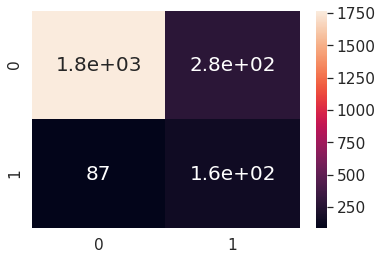

0.8601446364001607
{'depth': 10, 'learning_rate': 0.1}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

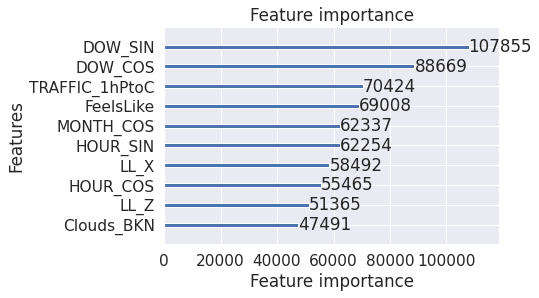

In [27]:
cat_model = train_CatBoost(x_new, y_new)
test_model(cat_model, x_test, y_test)
file_name = './cat_modelTrafficCount.pkl'
save_model(file_name, cat_model)
print(cat_model.best_estimator_)
print(cat_model.best_score_)
print(cat_model.best_params_)
plot_importance((cat_model.best_estimator_.feature_importances_ * 10000).astype(int), x.columns, max_num_features=10)